In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from plotting import *
from data_reading import *
from data_preproc import *
np.random.seed(0)
# sns.set()
# sns.set_style("whitegrid", {'axes.grid' : False})
HIST_PATH = "plots/var_hists/"

In [2]:
%load_ext autoreload
%autoreload
%aimport plotting

In [3]:
SIZE = 21
DATA_PATH = "data"

seeds = [0]
paths = [f"{DATA_PATH}/seed{i:d}/{t}_obs.csv" for i in seeds for t in "wg"]
all_data = load_obs_data(paths)

In [4]:
pt_bounds = 200, 400
data = all_data[all_data["pt"].between(*pt_bounds)]
print(f"Data set size: {data.shape[0]}")

Data set size: 85453


In [5]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=0, shuffle=True)
print(f"Train size: {train_data.shape[0]}; Test size: {test_data.shape[0]}")

Train size: 68362; Test size: 17091


In [19]:
features = ["Emean", "broad", "sub_rat", "log_eq", "pt<r/2", "pt<3r/2", "pt<r", "mass", "M1/2", "Nq/E"]

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
data_pipeline = make_pipeline(
    DataFrameSelector(features, pt_bounds=(200, 400)),
    StandardScaler(),
    PCA(),
    StandardScaler()
)
X_train = data_pipeline.fit_transform(train_data)
y_train = train_data["type"]

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics import fbeta_score, make_scorer
f_scorer = make_scorer(fbeta_score, beta=1.5)

svm_clf = SVC()
param_grid = [
    {"kernel": ["rbf"],
     "C": [0.01, 0.1, 1, 10],
     "gamma": [0.01, 0.1, 1, 10]}
    ]
grid_search = GridSearchCV(svm_clf, param_grid, cv=5,
                          scoring=f_scorer, n_jobs=16)
grid_search.fit(X_train[:10000], y_train[:10000])
print(f"Best f2 score: {grid_search.best_score_:.3f} for params: {grid_search.best_params_}")

Best f2 score: 0.845 for params: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}


In [22]:
svm_clf = SVC(**grid_search.best_params_).fit(X_train[:10000], y_train[:10000])

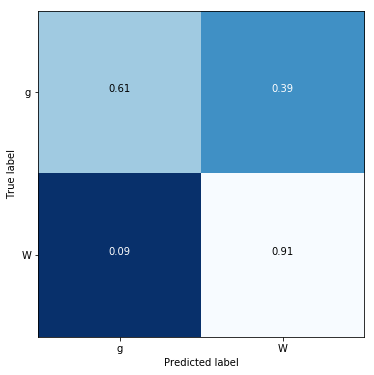

In [23]:
y_train_pred = svm_clf.predict(X_train)
fig, axis = plt.subplots(1,1, figsize=(8, 6))
plot_confusion_matrix(axis, confusion_matrix(y_train, y_train_pred), classes="gW", normalize=True)

In [24]:
X_test = data_pipeline.transform(test_data)
y_test = test_data["type"]
y_test_pred = svm_clf.predict(X_test)

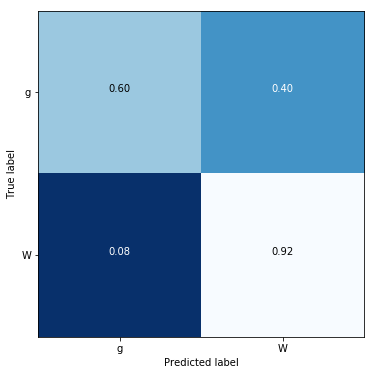

In [25]:
fig, axis = plt.subplots(1,1, figsize=(8, 6))
plot_confusion_matrix(axis, confusion_matrix(y_test, y_test_pred), classes="gW", normalize=True)